# 2. Physics Informed Neural Networks

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [36]:
device = torch.device('cuda:0')

# Dataset generation

# 1. 2D Rectangular grid

In [37]:
Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)
xy = torch.meshgrid(x,y)
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = 0*(xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

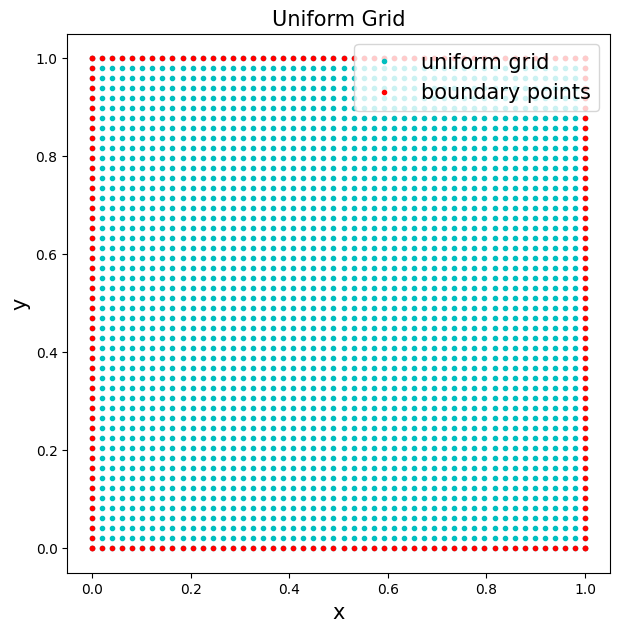

In [38]:
plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# Neural Network

In [39]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization
        
        self.act = nn.Tanh()
    
    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer, Additional Parameters

In [40]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                 # Pass data to GPU
u_bdry = u_bdry.to(device)
x, y = x.to(device), y.to(device)
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [41]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

# Mollifier

In [42]:
import math
from scipy.integrate import quad

def gaussian(x, mu, sigma):
    coefficient = 1.0 / (2 * math.pi * sigma)
    exponent = -(x - mu) ** 2 / (2 * sigma**2)
    return coefficient * torch.exp(exponent)

def bump(x,a=1.0):
    if type(x) == torch.Tensor:
        condition = (x.abs() < a)
        valid_values = torch.exp(x**2 / a**2*(a**2 - x**2)) 
        result = torch.where(condition, valid_values, torch.zeros_like(x))
        return result
    else:
        if abs(x) < a: return math.exp(x**2/a**2* (a**2 - x**2)) 
        else: return 0.0


def normalized_bump(x,a=1.0):


    integral, _ = quad(lambda x: bump(x,a), -a, a)
    coefficient = 1 / integral



    return coefficient * bump(x,a)

# 정규화된 Bump 함수 생성



# Parameters

In [43]:
# parameters in the PDE
k = 1
R_vec = torch.tensor([0.5, 0.5])
sigma = 0.1
mollifier = lambda x: normalized_bump(x, sigma)

In [44]:
mollifier(0)

4.9933358736546385

# Training

In [45]:
# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) \
              + 0.5*torch.pow(k*output, 2).view(-1,1) \
              - mollifier(torch.sqrt(xy_grid[:,0]**2 + xy_grid[:,1]**2))*output
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/Nx)
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        #clear_output(wait=True)
print('Training Finished.')

EPOCH :    100/ 20000 | Loss_ge : 0.0036595 | Loss_bdry : 0.0010377
EPOCH :    200/ 20000 | Loss_ge : 0.0026318 | Loss_bdry : 0.0003037
EPOCH :    300/ 20000 | Loss_ge : 0.0023685 | Loss_bdry : 0.0002558
EPOCH :    400/ 20000 | Loss_ge : 0.0020822 | Loss_bdry : 0.0002157
EPOCH :    500/ 20000 | Loss_ge : 0.0018350 | Loss_bdry : 0.0001812
EPOCH :    600/ 20000 | Loss_ge : 0.0016291 | Loss_bdry : 0.0001522
EPOCH :    700/ 20000 | Loss_ge : 0.0014609 | Loss_bdry : 0.0001280
EPOCH :    800/ 20000 | Loss_ge : 0.0013241 | Loss_bdry : 0.0001081
EPOCH :    900/ 20000 | Loss_ge : 0.0012118 | Loss_bdry : 0.0000919
EPOCH :   1000/ 20000 | Loss_ge : 0.0011179 | Loss_bdry : 0.0000786
EPOCH :   1100/ 20000 | Loss_ge : 0.0010372 | Loss_bdry : 0.0000678
EPOCH :   1200/ 20000 | Loss_ge : 0.0009661 | Loss_bdry : 0.0000590
EPOCH :   1300/ 20000 | Loss_ge : 0.0009018 | Loss_bdry : 0.0000517
EPOCH :   1400/ 20000 | Loss_ge : 0.0008427 | Loss_bdry : 0.0000457
EPOCH :   1500/ 20000 | Loss_ge : 0.0007880 | Lo

In [29]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)

In [30]:
integrand

tensor([[-3.7070e-03, -3.7087e-03, -3.7127e-03,  ...,  3.5228e-04,
          3.5228e-04,  3.5228e-04],
        [-1.9362e-03, -1.9370e-03, -1.9391e-03,  ...,  1.5948e-04,
          1.5948e-04,  1.5948e-04],
        [-7.6684e-04, -7.6717e-04, -7.6799e-04,  ...,  5.7135e-05,
          5.7135e-05,  5.7135e-05],
        ...,
        [ 1.9958e-03,  1.9966e-03,  1.9985e-03,  ...,  2.2914e-05,
          2.2914e-05,  2.2914e-05],
        [ 2.6762e-03,  2.6773e-03,  2.6799e-03,  ...,  3.7391e-05,
          3.7391e-05,  3.7391e-05],
        [ 3.5076e-03,  3.5090e-03,  3.5124e-03,  ...,  5.7013e-05,
          5.7013e-05,  5.7013e-05]], device='cuda:0', grad_fn=<SubBackward0>)

In [31]:
true = (xy_grid[:,0]*xy_grid[:,1]).view(-1,1)
pred = network(xy_grid)

print('Mean Square Error is : %8.7f' % F.mse_loss(pred, true).item())

Mean Square Error is : 0.1133646


In [32]:
from matplotlib import cm

In [33]:
print(z_detach.shape)

NameError: name 'z_detach' is not defined

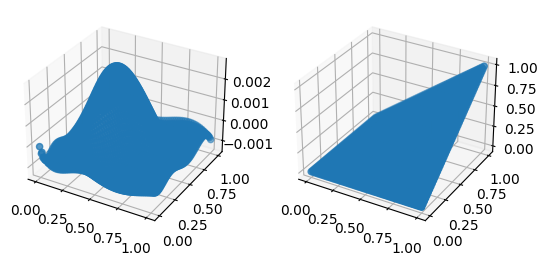

In [34]:
fig = plt.figure()
xy_detach = xy_grid.cpu().detach()
z_detach = pred.cpu().detach()
ax = fig.add_subplot(121, projection='3d')
xx = xy_detach[:,0]
yy = xy_detach[:,1]
zz = z_detach
ax.scatter(xx, yy, zz)

ax = fig.add_subplot(122, projection='3d')
zz_true = xx * yy
ax.scatter(xx, yy, zz_true)
plt.show()

(100, 100) (100, 100) (100, 100)


<Figure size 1200x600 with 0 Axes>

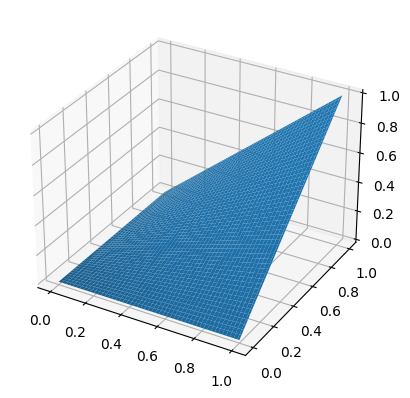

In [69]:
fig = plt.figure(figsize=(12,6))

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = X * Y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
print(X.shape, Y.shape, Z.shape)
plt.show()


In [70]:
print(z_detach)

tensor([[ 1.5184e-04],
        [-3.7171e-05],
        [-1.7963e-04],
        ...,
        [-1.9825e-04],
        [-1.8234e-04],
        [-1.6011e-04]])


In [71]:
print(Z)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.02030405e-04 2.04060810e-04 ... 9.89694929e-03
  9.99897970e-03 1.01010101e-02]
 [0.00000000e+00 2.04060810e-04 4.08121620e-04 ... 1.97938986e-02
  1.99979594e-02 2.02020202e-02]
 ...
 [0.00000000e+00 9.89694929e-03 1.97938986e-02 ... 9.60004081e-01
  9.69901031e-01 9.79797980e-01]
 [0.00000000e+00 9.99897970e-03 1.99979594e-02 ... 9.69901031e-01
  9.79900010e-01 9.89898990e-01]
 [0.00000000e+00 1.01010101e-02 2.02020202e-02 ... 9.79797980e-01
  9.89898990e-01 1.00000000e+00]]
